In [1]:
import sys 
# locate to the working folder
# sys.path.append("D:\\GitHub\\Clone\\planning\\ruixuan")
from ruixuan.turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle
import math
from collections import deque

In [2]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle',\
                           'Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
        
    def get_agent_traj(self, scene, target_label, junction, lane_list):
        veh_traj, ped_traj, cyclist_traj=[], [], [] 
        print(self.label_dict, self.label_dict[target_label])
        for idx, agent_label in enumerate(self.agent_list):
            print("xxx", idx, agent_label)
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 200  \
                and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    veh_traj.append(agent_loc)
#                     plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '\
#                              +self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and agent_loc.shape[0] > 100:
                    ped_traj.append(agent_loc)
        veh_traj, ped_traj, cyclist_traj = np.array(veh_traj), np.array(ped_traj), np.array(cyclist_traj)
        return veh_traj, ped_traj,cyclist_traj
#                     plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 100  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and  agent_loc.shape[0] > 100:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()


In [3]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/lab1/repo/planning/prediction-dataset"
# get config
cfg = load_config_data("/home/lab1/repo/planning/ruixuan/visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [4]:
junction_lane_merge = np.load('ruixuan/target_scene_index/lane_merge/scene_index(lane_merge)_Pedestrian.npy',allow_pickle = True)
junction_8KfB = np.load('ruixuan/target_scene_index/8KfB/scene_index(8KfB)_Pedestrian.npy',allow_pickle = True)

In [5]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [6]:
lane_list = {}
junction_boundary = {}
# extend lane sequences
lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']
lane_list['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]
# junction_boundary['8KfB'] = [(450,-2400),(500,-2360),(560,-2360),(560,-2420)]

grid_boundary={}
grid_boundary['8KfB']={'X':[450,600], 'Y':[-2450, -2300]}

In [7]:
def get_grid(intersection_id,grid_boundary):
    x = grid_boundary[intersection_id]['X']
    y = grid_boundary[intersection_id]['Y']
    x_ = np.linspace(x[0], x[1],150)
    y_ = np.linspace(y[0], y[1],150)
    x_mesh, y_mesh = np.meshgrid(x_, y_)
    return x_mesh, y_mesh

def locate_in_mesh(x_mesh, y_mesh, point):
    x, y = point[0], point[1]
    result=[]
#     print(x, y, x_mesh[0], x_mesh[-1], y_mesh[0], y_mesh[-1])
    if x>x_mesh[-1] or x<x_mesh[0] or y>y_mesh[-1] or y<y_mesh[0]:
        return None
    result = [math.floor(x-x_mesh[0]), math.floor(y-y_mesh[0])]
    return result

def plot_planned_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None,\
                        target_obs=None, planned=None, other_planned=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary['8KfB']['X'][0],grid_boundary['8KfB']['X'][1])
    plt.ylim(grid_boundary['8KfB']['Y'][0],grid_boundary['8KfB']['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)

    if veh is not None:
        for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
    if ped is not None:
        for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
    if cyc is not None:
        for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    if target_obs is not None:
        plt.plot(target_obs[:,0],target_obs[:,1], c='green',linewidth=1)
    if planned is not None:
        plt.plot(planned[:,0],planned[:,1], c='red',linewidth=1)
    if other_planned is not None:
        plt.plot(planned[:,0],planned[:,1], c='pink',linewidth=1)
    plt.axis('off')
    plt.show()
    

In [8]:
def animate_planned_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None,\
                            cyc=None, target_obs=None, planned=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    for idx in range(20):
        plt.figure(figsize=(18,18),frameon=False)
        plt.xlim(grid_boundary['8KfB']['X'][0],grid_boundary['8KfB']['X'][1])
        plt.ylim(grid_boundary['8KfB']['Y'][0],grid_boundary['8KfB']['Y'][1])
        for lane in lane_list[intersection_id]:
            plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='g',linewidth=1,label=lane)
            plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='g',linewidth=1)
    #         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
        x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
    #     print(x_mesh.shape, y_mesh[:,1])
        plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
        plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
    #     plt.title(intersection_id,fontsize=30)

    
        if veh is not None:
            for traj in veh: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='b',linewidth=1)
        if ped is not None:
            for traj in ped: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='orange',linewidth=1)
        if cyc is not None:
            for traj in cyc: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='cyan',linewidth=1)
                
        if target_obs is not None and planned is not None:
            if idx<10:
                plt.plot(target_obs[:idx,0],target_obs[:idx,1], c='green',linewidth=1)
            else:
                plt.plot(target_obs[:10,0],target_obs[:10,1], c='green',linewidth=1)
                plt.plot(planned[:idx-9,0],planned[:idx-9,1], c='red',linewidth=2)

        plt.axis('off')
        plt.ioff()
        plt.savefig("animation_fig/%s.png" %(str(idx)),  bbox_inches='tight',pad_inches = 0)
#         plt.show()

In [9]:
def _get_av2( prev2, prev, curr):
    v10 = np.linalg.norm(curr - prev)/0.5
    v9 = np.linalg.norm(prev - prev2)/0.5
    a = (v10-v9)/0.5
    return a, (v10+v9)/2
    
def _get_theta2(prev,curr):
    diff_x = curr[0]-prev[0] 
    diff_y = curr[1]-prev[1]
    indicator=1
    if diff_x<=0 and diff_y>=0:
        indicator=2
    elif diff_x<=0 and diff_y<=0:
        indicator=3
    else:
        indicator=4
    try:
        if diff_x !=0:
            tan = diff_y/diff_x
            # print("tan", tan, math.atan(tan)*180/math.pi)
            return math.atan(tan)*180/math.pi, indicator
        else:
            return 90, indicator
    except:
        return 90, indicator
def _get_guide(traj):
    guide=[]
    for i in range(9,19):
        a,_ = _get_av2(traj[i-1], traj[i], traj[i+1])
        theta, indicator = _get_theta2(traj[i], traj[i+1])
        guide.append([a, theta, indicator])
    return guide
    

def max_move(traj, guide):
    # [0.1, -3] [0.1, 3]
    traj_max=[]
    v1 =  np.linalg.norm(traj[10] - traj[9])/0.5
    v2 = np.linalg.norm(traj[9] - traj[8])/0.5
    v = (v1+v2)/2
    pos = traj[9]
    for t in range(10):
        traj_max.append(pos)
        guide_a, guide_theta, guide_indicator  = guide[t]

        a = guide_a+0.1
        theta=guide_theta+3


        distance = v*0.5+0.5*a*0.25
        radian = theta*math.pi/180
        dx, dy = abs(distance*math.cos(radian)), abs(distance*math.sin(radian))
        #update state
        if guide_indicator==1: # zone 1
            pos =[pos[0]+dx, pos[1]+dy]
        elif guide_indicator==2:
            pos =[pos[0]-dx, pos[1]+dy]
        elif guide_indicator==3:
            pos =[pos[0]-dx, pos[1]-dy]
        else:
            pos =[pos[0]+dx, pos[1]-dy]


        v = v+a*0.5
    return np.array(traj_max)

def min_move(traj, guide, unit=-3):
    # [0.1, -3] [0.1, 3]
    traj_min=[]
    v1 =  np.linalg.norm(traj[10] - traj[9])/0.5
    v2 = np.linalg.norm(traj[9] - traj[8])/0.5
    v = (v1+v2)/2
    pos = traj[9]
    for t in range(10):
        traj_min.append(pos)
        guide_a, guide_theta, guide_indicator  = guide[t]

        a = guide_a+0.2
        theta=guide_theta+unit


        distance = v*0.5+0.5*a*0.25
        radian = theta*math.pi/180
        dx, dy = abs(distance*math.cos(radian)), abs(distance*math.sin(radian))
        #update state
        if guide_indicator==1: # zone 1
            pos =[pos[0]+dx, pos[1]+dy]
        elif guide_indicator==2:
            pos =[pos[0]-dx, pos[1]+dy]
        elif guide_indicator==3:
            pos =[pos[0]-dx, pos[1]-dy]
        else:
            pos =[pos[0]+dx, pos[1]-dy]


        v = v+a*0.5
    traj_min.append(pos)
    return np.array(traj_min)

   

In [73]:
from core_xi import Graph
env2=Graph()
_ = env2.reset()
sample = env2.sample
task = sample['veh'][0]

/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [74]:
print(task.shape, task)

(20, 2) [[  570.894 -2357.743]
 [  573.329 -2355.052]
 [  575.435 -2352.604]
 [  578.092 -2349.464]
 [  580.539 -2346.334]
 [  582.924 -2343.073]
 [  585.315 -2339.543]
 [  587.357 -2336.558]
 [  589.265 -2333.446]
 [  591.466 -2329.457]
 [  593.133 -2325.98 ]
 [  595.02  -2322.416]
 [  596.857 -2319.001]
 [  598.474 -2315.83 ]
 [  599.722 -2313.323]
 [  601.502 -2309.682]
 [  602.56  -2306.988]
 [  603.996 -2304.225]
 [  604.972 -2301.687]
 [  606.05  -2299.558]]


In [75]:
guide =env2.target.guide
print(len(guide))
print(guide)

10
[[-2.799895401969044, 64.38524985001588, 1], [0.7070619998710885, 62.10051309793462, 1], [-0.6199749738744664, 61.72326174591882, 1], [-1.272984034391234, 62.98142969696499, 1], [-3.036114629966793, 63.53559604847138, 1], [5.009422550092486, 63.94706916604505, 1], [-4.634026963327328, 68.5588441000521, 1], [0.8783114887752959, 62.5379752870222, 1], [-1.5787515635768514, 68.96551457416956, 1], [-1.3313297574732328, 63.145036370820975, 1]]


In [76]:
v = env2.target.v
a = env2.target.a
prev_pos = env2.target.pos
new_pos=None
pos=[]
for t in range(0,10):
    guide_a, guide_theta, guide_indicator = guide[t]


    distance = v*0.5+0.5*guide_a*0.25
    radian = guide_theta*math.pi/180
    dx, dy = abs(distance*math.cos(radian)), abs(distance*math.sin(radian))
            #update state
    if guide_indicator==1: # zone 1
        new_pos=[prev_pos[0]+dx, prev_pos[1]+dy]
    elif guide_indicator==2:
        new_pos=[prev_pos[0]-dx, prev_pos[1]+dy]
    elif guide_indicator==3:
        new_pos = [prev_pos[0]-dx, prev_pos[1]-dy]
    else:
        new_pos = [prev_pos[0]+dx, prev_pos[1]-dy]
    pos.append(new_pos)
    prev_pos = new_pos
    v = v+guide_a*0.5

        
    

(10, 2)
(20, 2)


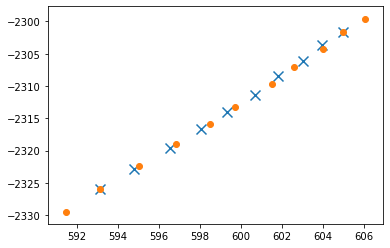

In [77]:
pos=np.array(pos)
print(pos.shape)
plt.scatter(pos[:,0], pos[:,1], s=100, marker='x')
plt.scatter(task[9:,0], task[9:,1])
print(task.shape)

In [78]:
#reference line with constant speed

In [93]:
def _get_guide2(traj):
    ref= list(traj[:10])
    prev_pos = traj[9]
    dsum=0
    for i in range(9,19):
        dsum+= np.linalg.norm(traj[i] - traj[i+1])
#     v = dsum/5
    v =env2.target.v
    print(dsum, v)
    
    for t in range(0,10):
        guide_a, guide_theta, guide_indicator = env2.target.guide[t]

        
        
        distance = v*0.5
        radian = guide_theta*math.pi/180
        dx, dy = abs(distance*math.cos(radian)), abs(distance*math.sin(radian))
                #update state
        if guide_indicator==1: # zone 1
            new_pos=[prev_pos[0]+dx, prev_pos[1]+dy]
        elif guide_indicator==2:
            new_pos=[prev_pos[0]-dx, prev_pos[1]+dy]
        elif guide_indicator==3:
            new_pos = [prev_pos[0]-dx, prev_pos[1]-dy]
        else:
            new_pos = [prev_pos[0]+dx, prev_pos[1]-dy]
        ref.append(new_pos)
        prev_pos = new_pos
        
#     for i in range(9,19):
#         a,_ = _get_av2(ref[i-1], ref[i], ref[i+1])
#         theta, indicator = _get_theta2(traj[i], traj[i+1])
#         guide.append([a, theta, indicator])
        
    return np.array(ref)


    
g2pos = _get_guide2(task)
print(g2pos.shape, task.shape)

33.292909819934984 8.41189138117142
(20, 2) (20, 2)


In [94]:
# plt.scatter()

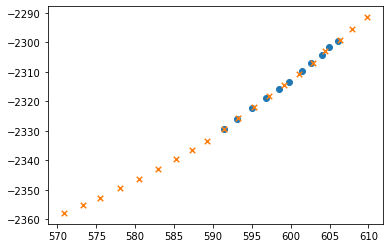

In [95]:
plt.scatter(task[9:,0], task[9:,1])
g2pos=np.array(g2pos)
plt.scatter(g2pos[:,0], g2pos[:,1], s= 30, marker='x')